# Mechanics of TensorFlow

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tf/02-mechanics.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

In this notebook, we take a deeper dive into lower-level features of TensorFlow, which will allow us to implement more advanced deep learning models. These include accessing and modifying layer weights and gradients, performing automatic differentiation, and creating static computation graphs from ordinary Python code.

**References:** {cite}`RaschkaMirjalili2019` [[Keras API](https://keras.io/api/)] [[`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function)]

In [1]:
import warnings
from pathlib import Path

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline


def set_random_seed(seed=0, deterministic=False):
    tf.keras.utils.set_random_seed(seed)
    if deterministic:
        tf.config.experimental.enable_op_determinism()


DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
set_random_seed(seed=RANDOM_SEED)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Static graph execution

Computations with eager execution are not as efficient as the static graph execution which are precompiled. TensorFlow provides a tool called **AutoGraph** that can automatically transform Python code into TensorFlow graph code for faster execution. Fortunately for us, TensorFlow provides a simple mechanism for compiling a normal Python function to do exactly this: simply wrap `tf.function(eager_func)` or use the `@tf.function` decorator in the function definition.

### Tracing mechanism 

Note that while TensorFlow graphs require static types and shapes, 
`tf.function` readily supports dynamic typing by creating multiple static graphs under the hood for different input signatures. For example, the following code calls the function with different input signatures:

In [2]:
def f(x, y, z):
    return x + y + z

f_graph = tf.function(f)
tf.print('Scalar Inputs:', f_graph(1, 2, 3))
tf.print('Rank 1 Inputs:', f_graph([1], [2], [3]))
tf.print('Rank 2 Inputs:', f_graph([[1]], [[2]], [[3]]))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Scalar Inputs: 6
Rank 1 Inputs: [1, 2, 3]
Rank 2 Inputs: [[1], [2], [3]]


2022-08-22 17:54:46.717077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-22 17:54:46.717336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-22 17:54:46.738898: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-22 17:54:46.759692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-22 17:54:46.779765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


TensorFlow uses a **tracing mechanism** to construct a graph based on the input arguments. For this tracing mechanism, TensorFlow generates a tuple of keys based on the input signatures
given for calling the function. The generated keys are as follows:
* For `tf.Tensor` arguments, the key is based on their shapes and `dtypes`.
* For Python types, such as lists, their `id()` is used to generate cache keys.
* For Python primitive values, the cache keys are based on the input values.

Upon calling such a decorated function, TensorFlow will check whether a graph with
the corresponding key has already been generated. If such a graph does not exist,
TensorFlow will generate a new graph and store the new key. Graph creation includes TensorFlow as well as Python operations as nodes. See [here](https://blog.tensorflow.org/2018/07/autograph-converts-python-into-tensorflow-graphs.html) for details.

If we want to limit the way a function can be called, we can specify its input signature
via a tuple of `tf.TensorSpec` objects when defining the function. For example, the following modifies the previous function so that only rank 1 tensors of
type `tf.int32` are allowed as input:

In [3]:
def f(x, y, z):
    return x + y + z

f_graph = tf.function(f, input_signature=(
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32)
    )
)

tf.print('Rank 1 Inputs:', f_graph([1], [2], [3]))

Rank 1 Inputs: [6]


2022-08-22 17:54:46.847439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


We get an error if we pass a tensor with different shape:

In [4]:
try:
    tf.print('Rank 1 Inputs:', f_graph([[1]], [[2]], [[3]]))
except Exception as e:
    print(e)

Python inputs incompatible with input_signature:
  inputs: (
    [[1]],
    [[2]],
    [[3]])
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).


### Timing static execution runs

In this section, we define a function that takes in an eager function `f` and plots the timings for evaluating `f` eagerly on `x` versus evaluating on its static graph version `tf.function(f)`. As discussed above, the static graph is built after warming up once on an input `x` with its particular shape and type through the tracing mechanism.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def compare_timings(f, x, n):
    # Define functions
    eager_function = f
    graph_function = tf.function(f)

    # Timing
    graph_time = timeit(lambda: graph_function(*x), number=n)
    eager_time = timeit(lambda: eager_function(*x), number=n)
    
    return {
        'graph': graph_time,
        'eager': eager_time
    }

**Timing.** Comparing static graph execution with eager execution on a dense network:

In [6]:
from tensorflow.keras.layers import Flatten, Dense

# Model building
model = kr.Sequential()
model.add(Flatten())
model.add(Dense(256, "relu"))
model.add(Dense(256, "relu"))
model.add(Dense(256, "relu"))
model.add(Dense(10, "softmax"))

# Define input + functions
u = tf.random.uniform([100, 28, 28])
mlp_times = compare_timings(model, [u], n=10000);

2022-08-22 17:54:47.238726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Comparing timings with convolution operations:

In [7]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D

# Build model
conv_model = kr.Sequential()
conv_model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
conv_model.add(AveragePooling2D())
conv_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
conv_model.add(AveragePooling2D())

# Plot timings
u = tf.random.uniform([100, 28, 28, 1])
conv_times = compare_timings(conv_model, [u], n=10000);

2022-08-22 17:55:03.251687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Comparing timings on many extremely small operations:

In [8]:
def small_dense_layer(x):
    w = tf.random.uniform(shape=(3, 1), dtype=tf.float16)
    b = tf.random.uniform(shape=(1,), dtype=tf.float16)
    return tf.add(tf.matmul(x, w), b)

# Plot timings
x = tf.random.uniform(shape=(1, 3), dtype=tf.float16)
small_times = compare_timings(small_dense_layer, [x], n=10000);

2022-08-22 17:55:13.450256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


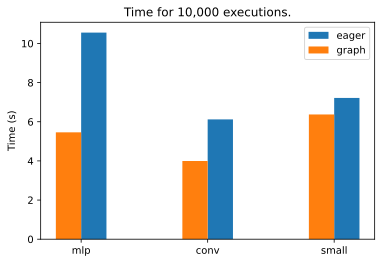

In [9]:
models = ['mlp','conv','small']
eager = [eval(m + '_times')['eager'] for m in models]
graph = [eval(m + '_times')['graph'] for m in models]
x = np.arange(len(models))


plt.bar(x + 0.1, eager, width=0.2, label='eager')
plt.bar(x - 0.1, graph, width=0.2, label='graph')
plt.xticks(x, models)
plt.ylabel("Time (s)")
plt.title("Time for 10,000 executions.")
plt.legend();

The above results show that graph execution can be faster can be faster than eager code, especially for graphs with expensive operations. But for graphs with few expensive operations (like convolutions), you may see little speedup or even worse with cheap operations due to the overhead of tracing.

For example, if we fail to persist a static graph and create multiple graphs, we get the following warning. The error message highlights cases where we make inefficient use of tracing. Recall the rules above for generating keys for static graphs based on the input. This [guide](https://www.tensorflow.org/guide/function#tracing) on tracing mechanism is also helpful. 

> WARNING:tensorflow:6 out of the last 6 calls to <keras.engine.sequential.Sequential object at 0x28575dfa0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop.

## TensorFlow `Variable`

A `Variable` is a special `Tensor` object
that allows us to store and update the parameters of our models during training.
This can be created by just calling the `tf.Variable` class on user-specified
initial values. 

In [10]:
a = tf.Variable(initial_value=3.0, name='var_a') # float32 by default.
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=['c'], dtype=tf.string)

print(a)
print(b)
print(c)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.0>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'c'], dtype=object)>


Note that initial value is required. TF variables have an attribute called `trainable`, which by default is set to `True`. Higher-level APIs such as Keras will use this attribute to manage the trainable variables and non-trainable ones. You can define a non-trainable `Variable` as follows:

In [11]:
w = tf.Variable(3.0, trainable=False)
print(w.trainable)

False


### Modifying the value of a variable

The values of a `Variable` can be efficiently modified by running some operations
such as `.assign()`, `.assign_add()` and related methods. When the `read_value` argument is set to `True` (default), these operations will automatically return the new values after updating the current values of the `Variable`.

In [12]:
w.assign(0.0, read_value=True)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0>

Setting the `read_value` to `False` will suppress the automatic return of the updated value but the `Variable` will still be updated in place.

In [13]:
tf.print(w.assign_add(-1.0, read_value=False))
tf.print(w)

None
-1


### Initializing a TensorFlow module

In practice, we usually define and initialize a `Variable` inside a `tf.Module` class. In the example below, we define two variables one trainable one and another non-trainable. These variables can be accessed using the `.variables` and `.trainable_variables` attribute of TF modules.

In [14]:
class MyModule(tf.Module):
    def __init__(self):
        init = kr.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)


m = MyModule()
print("All module variables:", [v.shape for v in m.variables])
print("Trainable variables:", [v.shape for v in m.trainable_variables])

All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variables: [TensorShape([2, 3])]


### Variables and TF functions

Note that if we define a TF variable inside a pure Python function, then this variable will be initialized every time the function is called. Since the static graph will try to reuse the variable based on tracing and graph creation, TF prevents variable initialization inside a decorated TF function. 

One way to avoid this problem is to define the `Variable` outside of the decorated
function and use it inside the function &mdash; this is not recommended with a global scope. Instead, you should define a class to manage this dependency in a separate namespace.

In [15]:
@tf.function
def f(x):
    w = tf.Variable([3.0])
    return x * w

# Testing
try:
    f(1.0)
except Exception as e:
    print(e)

in user code:

    File "/var/folders/rs/545s34211072bjwdz2jf8zf40000gq/T/ipykernel_39982/2632006634.py", line 3, in f  *
        w = tf.Variable([3.0])

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.



Instead do:

In [16]:
# Declare variable outside function <- make sure to not pollute the global namespace
w = tf.Variable([3.0])

@tf.function
def f(x):
    return x * w

# Testing
try:
    tf.print(f(1.0))
except Exception as e:
    print(e)

[3]


2022-08-22 17:55:27.796885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Autograd with `GradientTape`

TensorFlow supports automatic differentiation which implements symbolic differentiation for each operation defined in the language. For nested functions, TF provides a context called `GradientTape` for calculating gradients of these computed tensors with respect to its dependent nodes in the computation graph. This allows TensorFlow needs to remember what operations happen in what order during the forward pass. This list of operations is traversed backwards during [backward pass](https://particle1331.github.io/fitter-happier-models/notebooks/language-modeling/00-backprop.html) to compute the weight gradients.

### Parameter gradients

In order to compute these gradients, we have to record the computations within the context of `tf.GradientTape`. Note that the shape of `tape.gradient(loss, w)` is the same as that of `w`.  

In [17]:
# scope outside tf.GradientTape
w = tf.Variable(1.0)
b = tf.Variable(0.5)

# data
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, w)
tf.print("∂(loss)/∂w =", grad)
tf.print(2 * (y - w*x - b) * (-x)) # symbolic

∂(loss)/∂w = -0.559999764
[-0.559999764]


### Higher-order gradients

It turns out that TF supports stacking gradient tapes which allow us to compute higher order derivatives:

In [18]:
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        z = tf.add(tf.multiply(w, x), b)
        loss = tf.reduce_sum(tf.square(y - z))
    grad_w = inner_tape.gradient(loss, w)
grad_wb = outer_tape.gradient(grad_w, b)

tf.print("∂²(loss)/∂w∂b =", grad_wb)
tf.print(2 * (-1) * (-x)) # symbolic

∂²(loss)/∂w∂b = 2.8
[2.8]


### Non-trainable parameters

Recall that `GradientTape` automatically supports the gradients for trainable variables.
But for non-trainable variables and other `Tensor` objects, we have to manually add them using `tape.watch()`.

In [19]:
with tf.GradientTape() as tape:
    tape.watch(x) # <-
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, x)
tf.print("∂(loss)/∂x =", grad)
tf.print(2 * (y - w*x - b) * (-w)) # check symbolic

∂(loss)/∂x = [-0.399999857]
[-0.399999857]


### Persisting the tape

Note that the tape will keep the resources only for a single gradient computation by default. So
after calling `tape.gradient()` once, the resources will be released and the tape will
be cleared. If we want to compute more than one gradient, we need to persist it (less memory efficient).

In [20]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

try:
    tf.print("∂(loss)/∂w =", tape.gradient(loss, w))
    tf.print("∂(loss)/∂x =", tape.gradient(loss, x))
except Exception as e:
    print(e)

∂(loss)/∂w = -0.559999764
A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [21]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

tf.print("∂(loss)/∂w =", tape.gradient(loss, w))
tf.print("∂(loss)/∂x =", tape.gradient(loss, x)) # grad_x has same shape as x

∂(loss)/∂w = -0.559999764
∂(loss)/∂x = [-0.399999857]


### Optim step to update parameter gradients

During SGD, we are computing gradients of a loss term with respect to model weights, which we use to update the weights according to some rule defined by an optimization algorithm. For Keras optimizers, we can do this by  using `.apply_gradients`:

In [22]:
grad_w = tape.gradient(loss, w)
grad_b = tape.gradient(loss, b)
lr = 0.1
tf.print('w =', w)
tf.print('b =', b)
tf.print('λ =', lr)
tf.print('grad_[w, b] =', [grad_w, grad_b])

# Define keras optimizer; apply optimizer step
optimizer = kr.optimizers.SGD(learning_rate=lr)
optimizer.apply_gradients(zip([grad_w, grad_b], [w, b]))

# Print updates
tf.print()
tf.print('w - λ·∂(loss)/∂w ≟', w)
tf.print('b - λ·∂(loss)/∂b ≟', b)

w = 1
b = 0.5
λ = 0.1
grad_[w, b] = [-0.559999764, -0.399999857]

w - λ·∂(loss)/∂w ≟ 1.056
b - λ·∂(loss)/∂b ≟ 0.539999962


Checks out nicely.